
# IGATP Spatial Analysis in the Porto Metropolitan Area

This notebook performs spatial analysis and visualization of the **Perceived Global Tourist Attractiveness Index (IGATP)** across the municipalities of the Porto Metropolitan Area.

We will:
- Load geospatial and index data.
- Filter only the points within the AMP polygon shapefile.
- Visualize the spatial distribution of IGATP and its subindices using georeferenced points.
- Apply KDE (Kernel Density Estimation) interpolation to represent these values across municipalities.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np
from matplotlib.path import Path
from esda import Moran
from libpysal.weights import Queen
from libpysal.weights import lag_spatial
from esda.moran import Moran_Local

## 1. Load Data

In [2]:
# Composite index with coordinates
df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/6_unsupervised_learning/composite_index_with_clusters.csv")

# Load municipalities shapefile
gdf_mun = gpd.read_file("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/1_data_collection/spatial_data_AMP/shape_CAOP_Conc_AMP.shp").to_crs("EPSG:4326")
gdf_freg = gpd.read_file("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/1_data_collection/spatial_data_AMP/shape_CAOP_Freg_AMP.shp").to_crs("EPSG:4326")


In [3]:
df.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto', 'Latitude_Nova', 'Longitude_Nova',
       'Endereço_Limpo', 'shrinkage', 'Rating_Bayes', 'Nome_Local',
       'Avg_Polarity', 'Rating_Bayes_norm', 'Popularity_norm',
       'Sentiment_norm', 'IGATP', 'cluster_k2', 'cluster_k3', 'cluster_k6',
       'cluster_k7', 'cluster_k8', 'cluster_k9', 'cluster_k7_pam',
       'cluster_k6_pam'],
      dtype='object')

In [4]:
gdf_mun.columns

Index(['DICO_left', 'Municipio_', 'Distrito_l', 'N_Freguesi', 'NUTSIII_le',
       'NUTSII_lef', 'NUTSI_left', 'Alt_Max_le', 'Alt_Min_le', 'Area_ha_le',
       'Perim_km_l', 'index_righ', 'DICO_right', 'Municipi_1', 'Distrito_r',
       'N_Fregue_1', 'NUTSIII_ri', 'NUTSII_rig', 'NUTSI_righ', 'Alt_Max_ri',
       'Alt_Min_ri', 'Area_ha_ri', 'Perim_km_r', 'geometry'],
      dtype='object')

## 2. Create GeoDataFrame from Points and Filter by Polygon

In [5]:
# Remove missing coordinates
df_filtered = df.dropna(subset=["Latitude_Nova", "Longitude_Nova"])

# Create points
geometry = [Point(xy) for xy in zip(df_filtered["Longitude_Nova"], df_filtered["Latitude_Nova"])]
gdf_points = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")

# Spatial join: keep only points within the AMP
gdf_points = gpd.sjoin(gdf_points, gdf_mun, how="inner", predicate="within")


## 3. Visualize IGATP and Subindices with Point Gradient

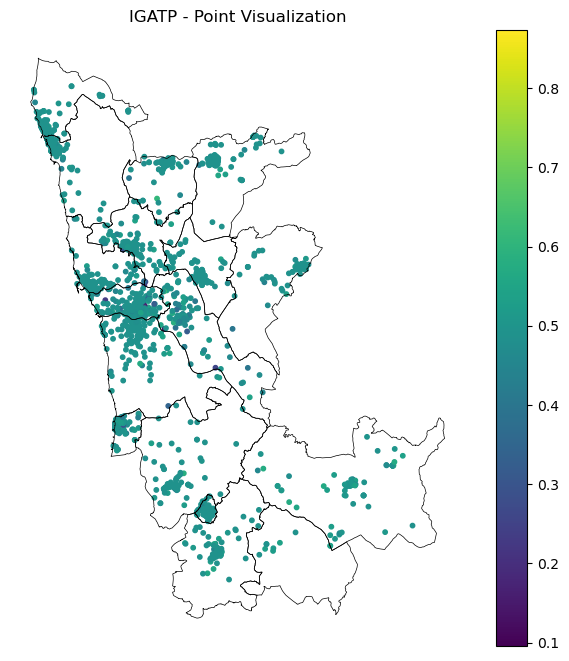

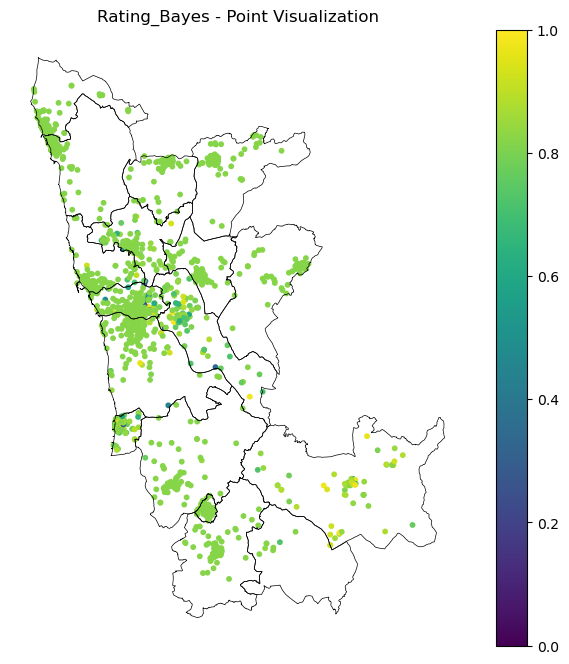

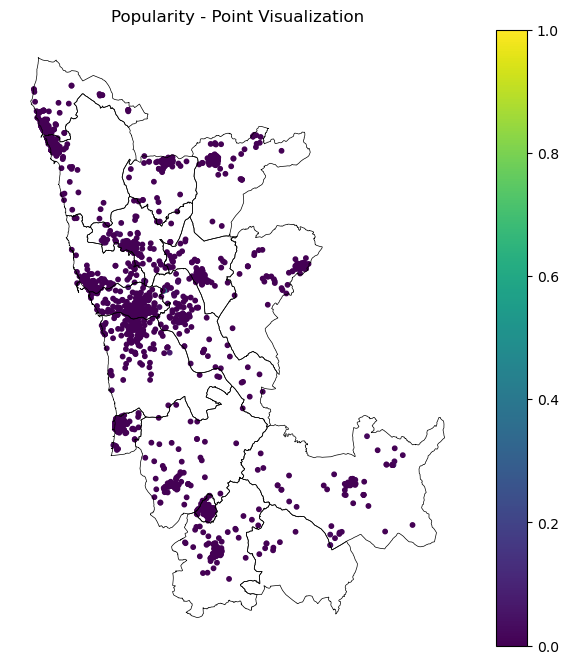

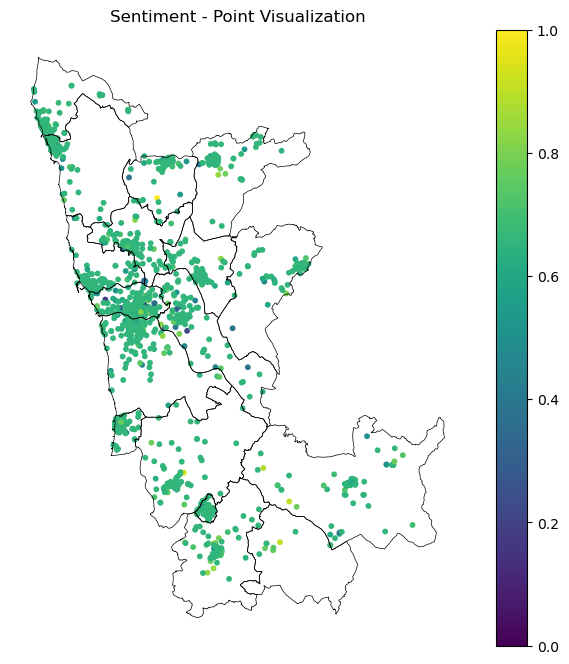

In [6]:
columns_to_plot = {
    "IGATP": "IGATP",
    "Rating_Bayes": "Rating_Bayes_norm",
    "Popularity": "Popularity_norm",
    "Sentiment": "Sentiment_norm"
}

for title, column in columns_to_plot.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_mun.boundary.plot(ax=ax, color="black", linewidth=0.5)
    gdf_points.plot(column=column, ax=ax, cmap="viridis", markersize=10, legend=True)
    ax.set_title(f"{title} - Point Visualization")
    ax.axis("off")
    plt.show()


In [30]:
# Lista de colunas a analisar
columns = ["Rating_Bayes_norm", "Popularity_norm", "Sentiment_norm", "IGATP"]

# Mostrar mínimo e máximo de cada coluna
for col in columns:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: mínimo = {min_val:.3f}, máximo = {max_val:.3f}")

Rating_Bayes_norm: mínimo = 0.000, máximo = 1.000
Popularity_norm: mínimo = 0.000, máximo = 1.000
Sentiment_norm: mínimo = 0.000, máximo = 1.000
IGATP: mínimo = 0.095, máximo = 0.873


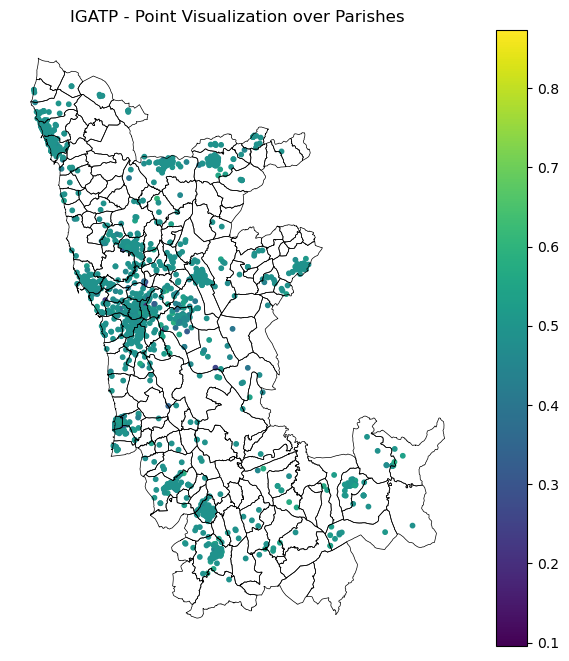

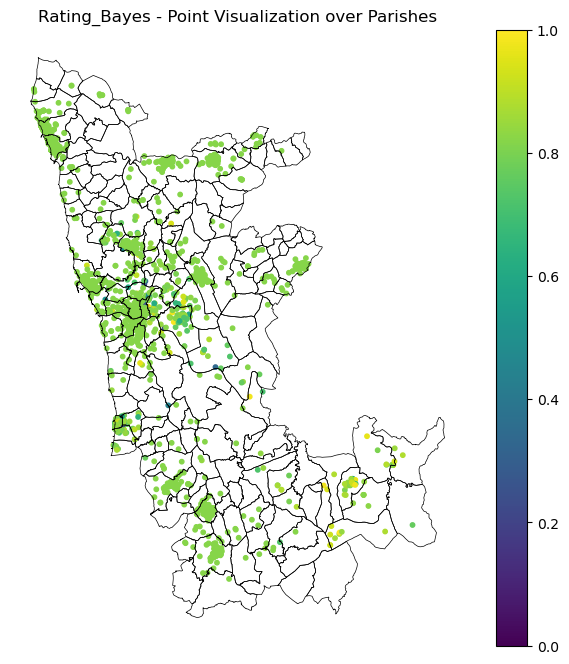

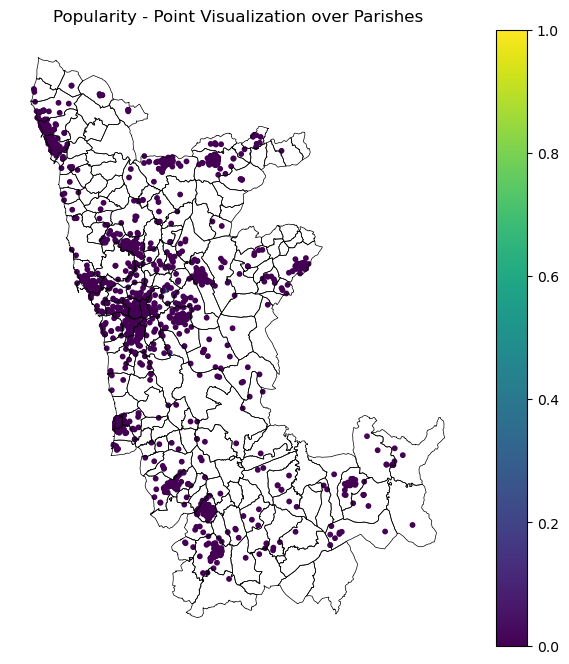

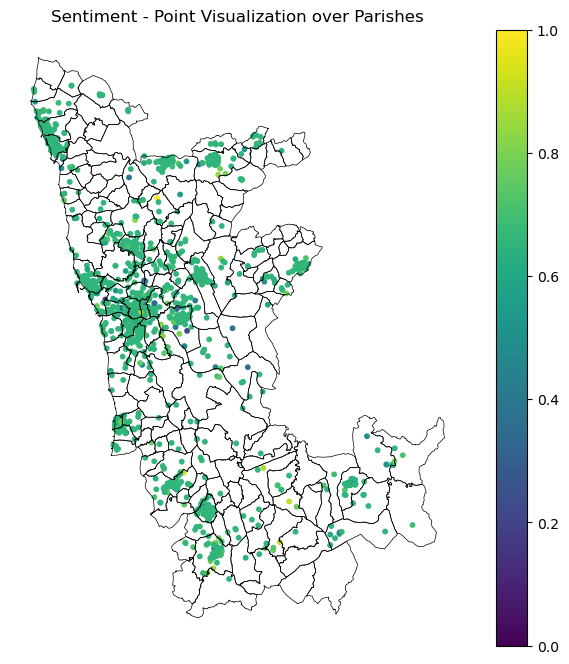

In [7]:
# Create point geometries
geometry = [Point(xy) for xy in zip(df_filtered["Longitude_Nova"], df_filtered["Latitude_Nova"])]
gdf_points = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")

# Perform spatial join to keep only points within the AMP parishes
gdf_points_freg = gpd.sjoin(gdf_points, gdf_freg, how="inner", predicate="within")

# Columns to plot
columns_to_plot = {
    "IGATP": "IGATP",
    "Rating_Bayes": "Rating_Bayes_norm",
    "Popularity": "Popularity_norm",
    "Sentiment": "Sentiment_norm"
}

# Loop to generate plots
for title, column in columns_to_plot.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_freg.boundary.plot(ax=ax, color="black", linewidth=0.5)
    gdf_points_freg.plot(column=column, ax=ax, cmap="viridis", markersize=10, legend=True)
    ax.set_title(f"{title} - Point Visualization over Parishes")
    ax.axis("off")
    plt.show()

## 4. Spatial Interpolation (KDE) Over AMP Territory

In [8]:
# Criar geometria para os pontos
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude_Nova'], df['Latitude_Nova']),
    crs="EPSG:4326"
)

# Garantir o mesmo sistema de coordenadas
gdf_mun = gdf_mun.to_crs("EPSG:4326")

# Remover a coluna index_right se existir no shapefile (evita erro)
if 'index_right' in gdf_mun.columns:
    gdf_mun = gdf_mun.drop(columns=['index_right'])

# Realizar o spatial join
gdf_joined = gpd.sjoin(gdf_points, gdf_mun, how="inner", predicate="within")


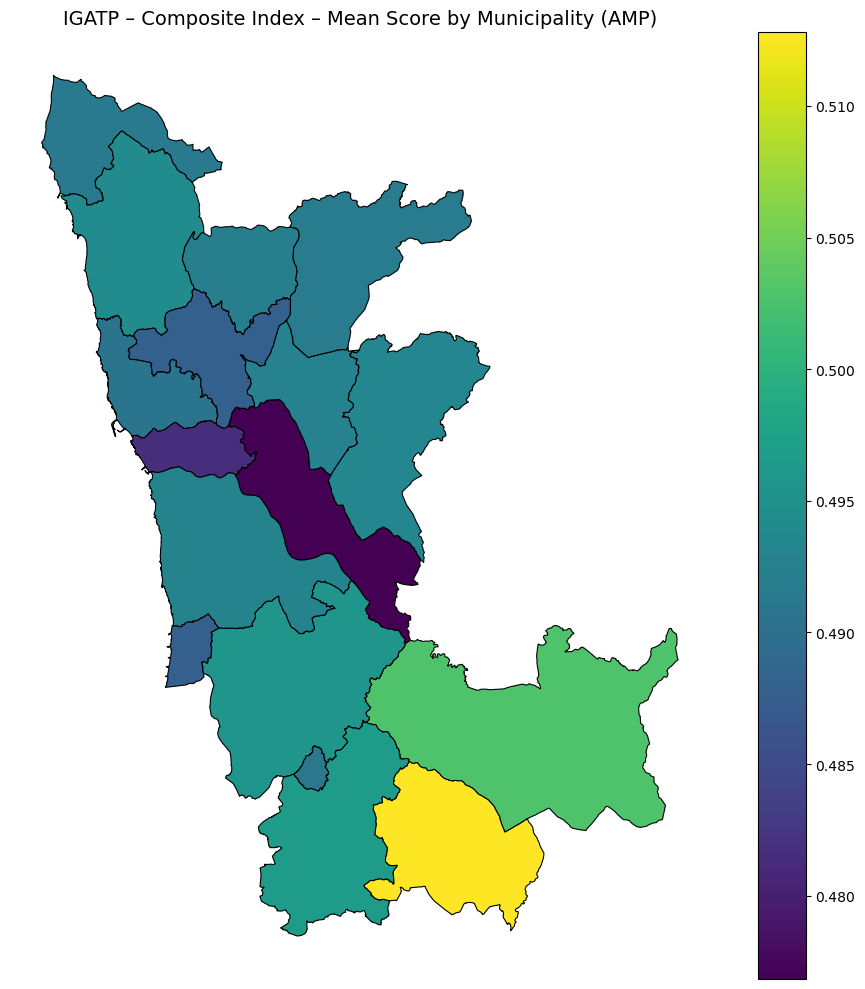

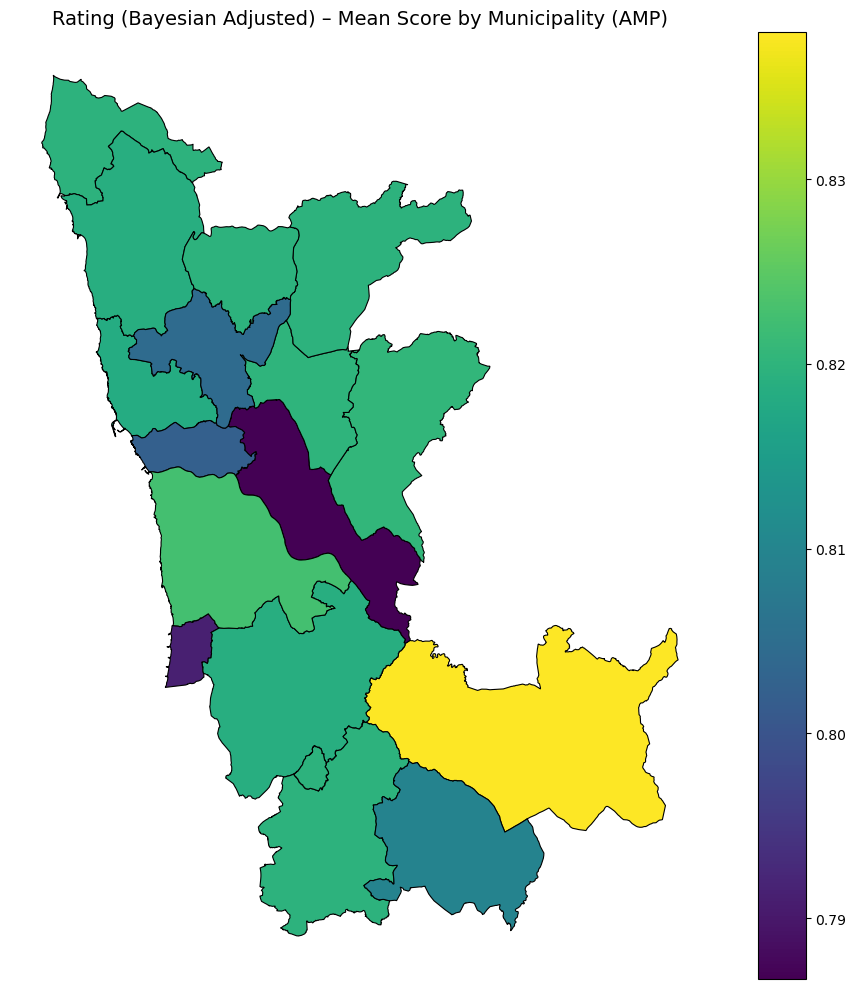

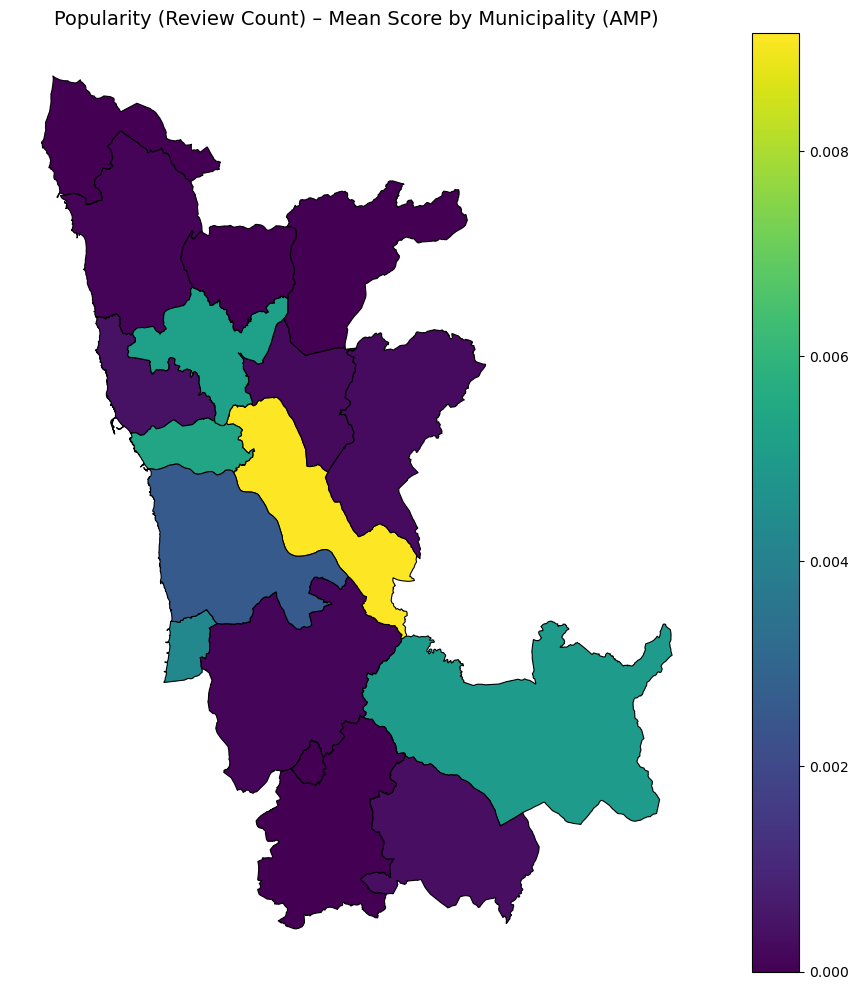

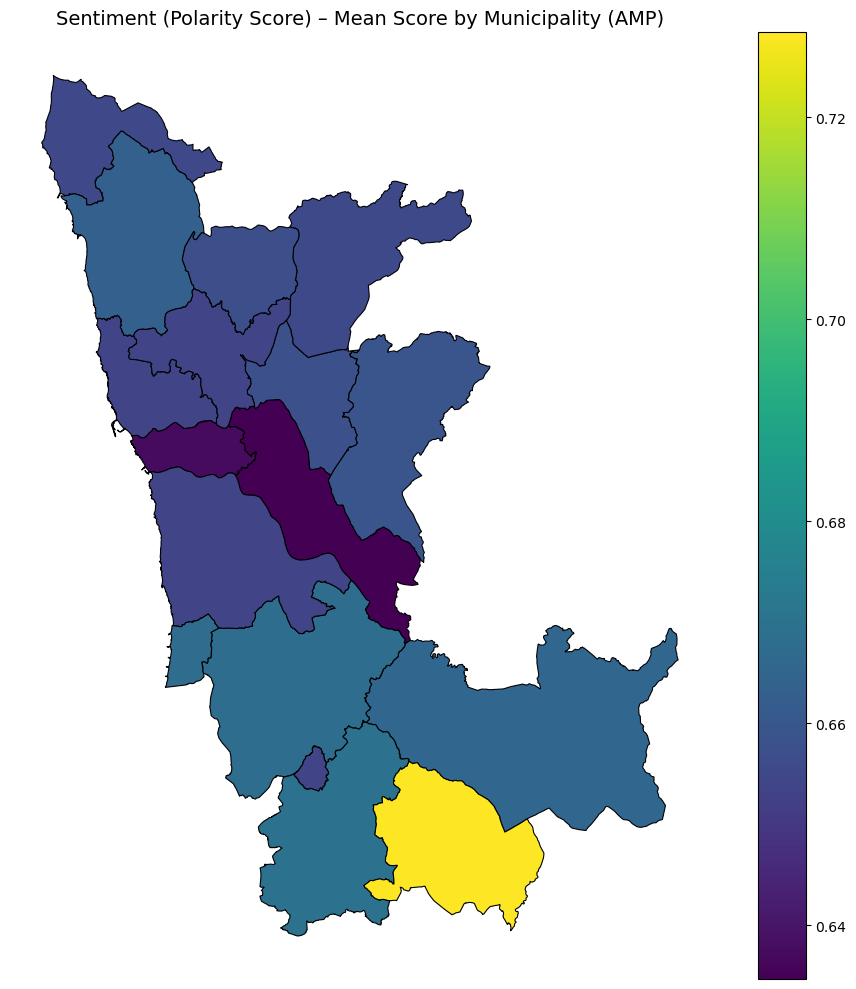

In [9]:
# Dicionário com os nomes dos índices a mapear
columns_to_map = {
    "IGATP – Composite Index": "IGATP",
    "Rating (Bayesian Adjusted)": "Rating_Bayes_norm",
    "Popularity (Review Count)": "Popularity_norm",
    "Sentiment (Polarity Score)": "Sentiment_norm"
}

# Loop para gerar um mapa por índice
for title, column in columns_to_map.items():
    # Agrupar por município (com base no spatial join) e calcular a média
    mun_mean = gdf_joined.groupby("DICO_right")[column].mean().reset_index()
    mun_mean.columns = ["DICO_right", f"{column}_mean"]

    # Juntar ao shapefile
    gdf_mun_mean = gdf_mun.merge(mun_mean, on="DICO_right", how="left")

    # Plot do mapa
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_mun_mean.plot(
        column=f"{column}_mean",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )
    ax.set_title(f"{title} – Mean Score by Municipality (AMP)", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

In [10]:
gdf_mun_mean.columns

Index(['DICO_left', 'Municipio_', 'Distrito_l', 'N_Freguesi', 'NUTSIII_le',
       'NUTSII_lef', 'NUTSI_left', 'Alt_Max_le', 'Alt_Min_le', 'Area_ha_le',
       'Perim_km_l', 'index_righ', 'DICO_right', 'Municipi_1', 'Distrito_r',
       'N_Fregue_1', 'NUTSIII_ri', 'NUTSII_rig', 'NUTSI_righ', 'Alt_Max_ri',
       'Alt_Min_ri', 'Area_ha_ri', 'Perim_km_r', 'geometry',
       'Sentiment_norm_mean'],
      dtype='object')

In [11]:
# Criar base
gdf_mun_mean = gdf_mun.copy()

# Adicionar cada índice como uma nova coluna
for title, column in columns_to_map.items():
    mun_mean = gdf_joined.groupby("DICO_right")[column].mean().reset_index()
    mun_mean.columns = ["DICO_right", f"{column}_mean"]
    gdf_mun_mean = gdf_mun_mean.merge(mun_mean, on="DICO_right", how="left")

In [12]:
gdf_mun_mean.columns

Index(['DICO_left', 'Municipio_', 'Distrito_l', 'N_Freguesi', 'NUTSIII_le',
       'NUTSII_lef', 'NUTSI_left', 'Alt_Max_le', 'Alt_Min_le', 'Area_ha_le',
       'Perim_km_l', 'index_righ', 'DICO_right', 'Municipi_1', 'Distrito_r',
       'N_Fregue_1', 'NUTSIII_ri', 'NUTSII_rig', 'NUTSI_righ', 'Alt_Max_ri',
       'Alt_Min_ri', 'Area_ha_ri', 'Perim_km_r', 'geometry', 'IGATP_mean',
       'Rating_Bayes_norm_mean', 'Popularity_norm_mean',
       'Sentiment_norm_mean'],
      dtype='object')

## 5. Interpolation of the IGATP Index by Parish

In [13]:
gdf_freg.columns

Index(['DICOFRE_le', 'Freguesia_', 'Municipio_', 'Distrito_l', 'Area_ha_le',
       'Des_Simpli', 'index_righ', 'DICOFRE_ri', 'Freguesi_1', 'Municipi_1',
       'Distrito_r', 'Area_ha_ri', 'Des_Simp_1', 'geometry'],
      dtype='object')

In [14]:
# Perform spatial join between IGATP points and parish polygons
gdf_joined_freg = gpd.sjoin(gdf_points, gdf_freg, predicate="within")

# Compute mean IGATP index per parish
media_freg = gdf_joined_freg.groupby("DICOFRE_le")["IGATP"].mean().reset_index()
media_freg.columns = ["DICOFRE_le", "IGATP_mean"]

# Merge aggregated values back into parish shapefile
shape_freg_joined = gdf_freg.merge(media_freg, on="DICOFRE_le", how="left")


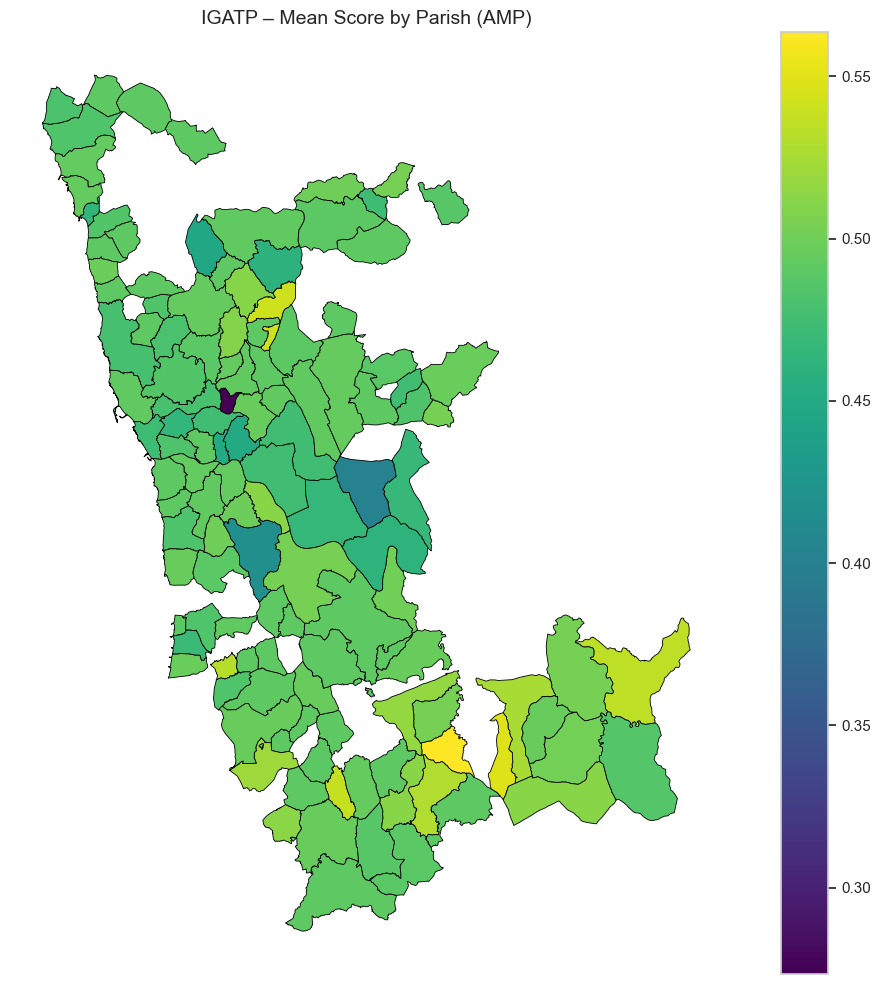

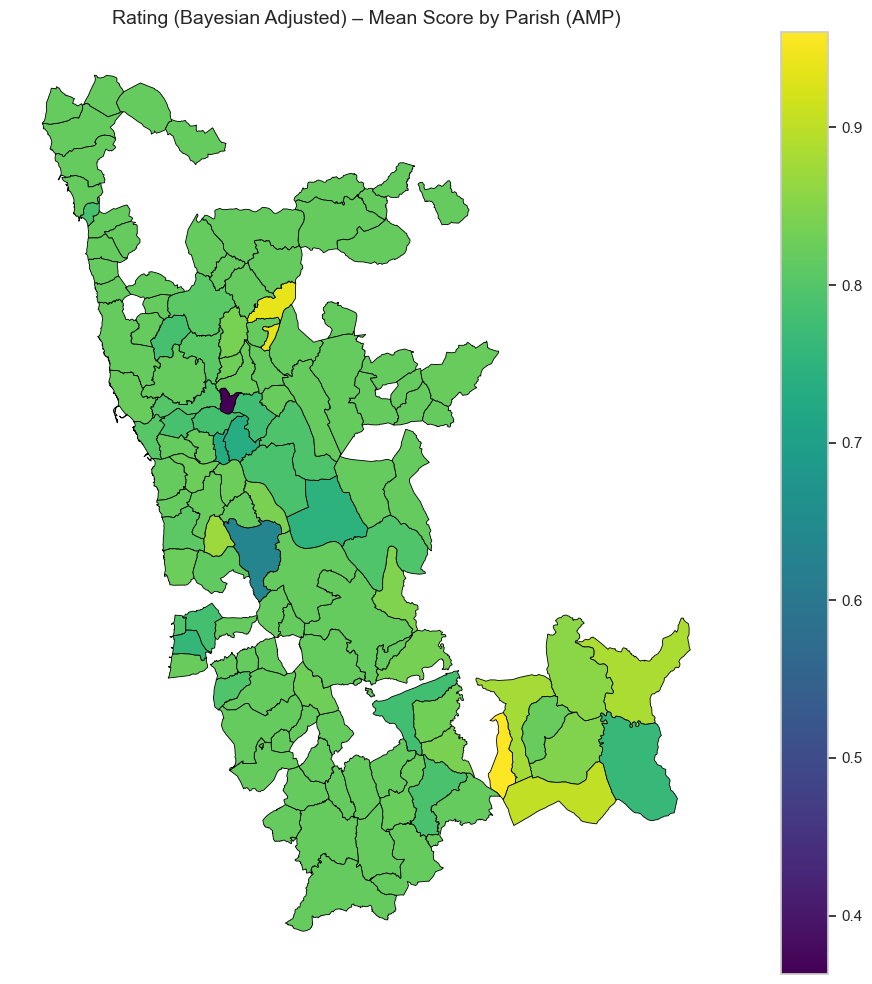

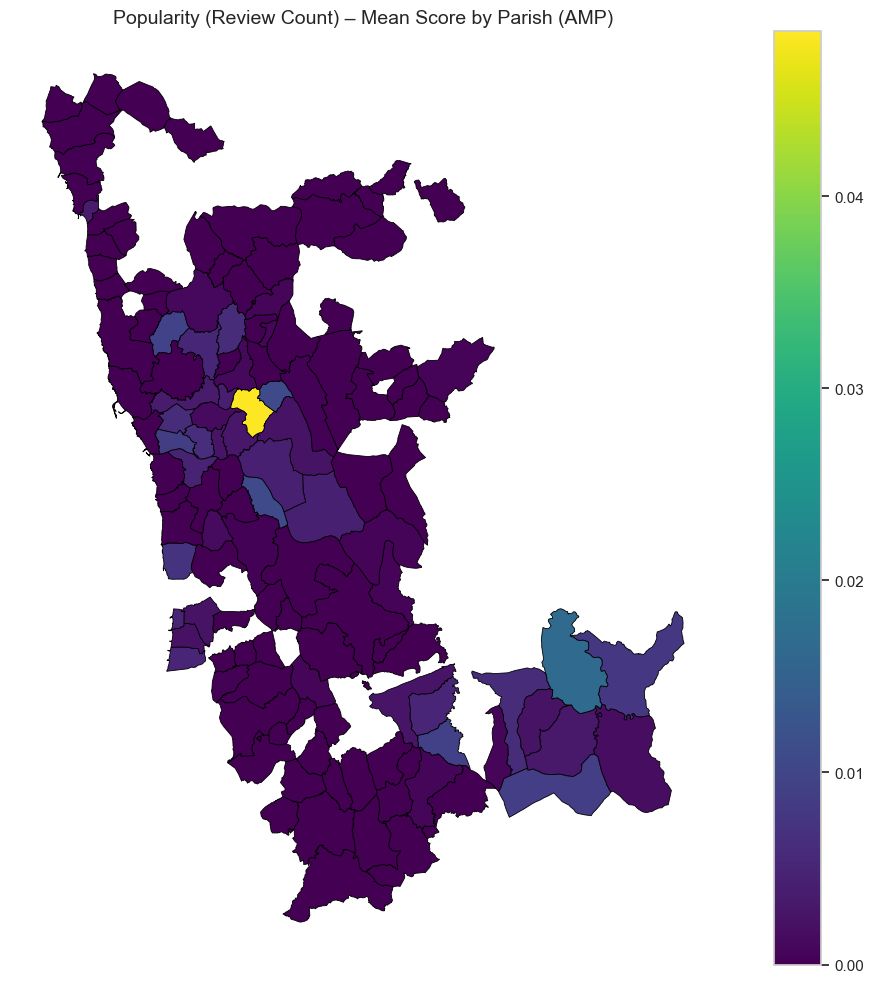

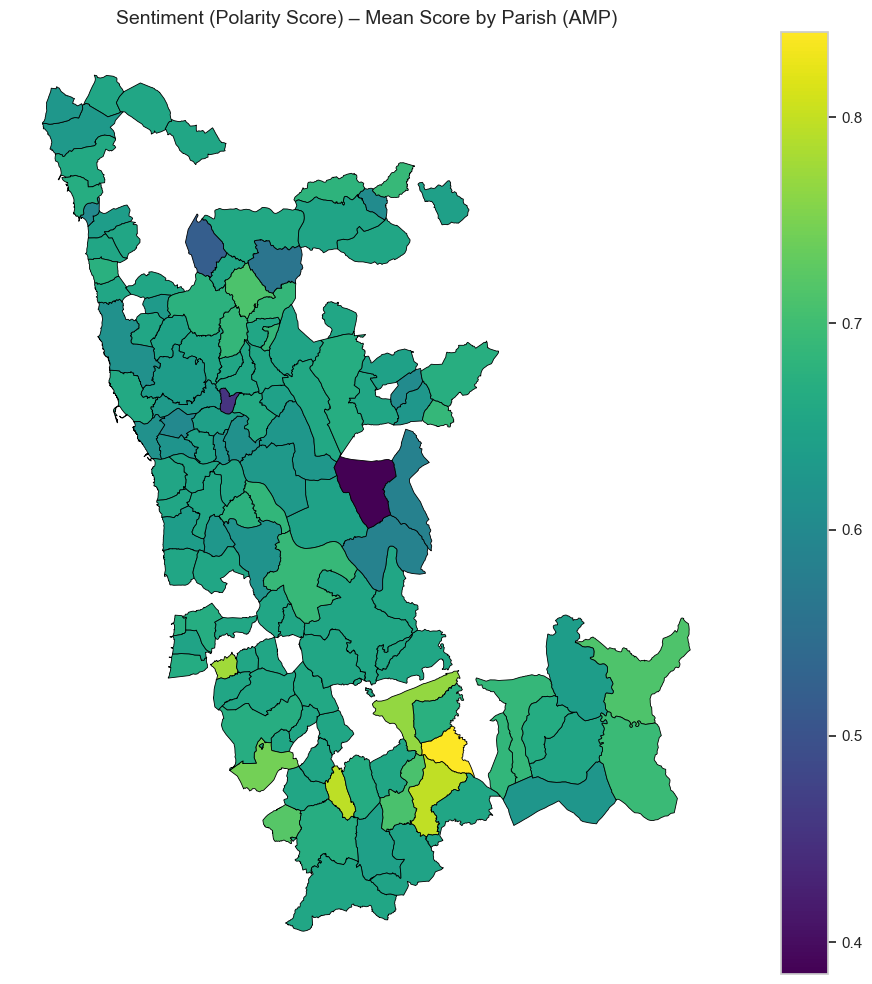

In [31]:
# Lista dos sub-índices (além do IGATP, se quiseres incluir novamente)
columns_to_map = {
    "IGATP": "IGATP",
    "Rating (Bayesian Adjusted)": "Rating_Bayes_norm",
    "Popularity (Review Count)": "Popularity_norm",
    "Sentiment (Polarity Score)": "Sentiment_norm"
}

# Loop para cada índice
for title, column in columns_to_map.items():
    # Agrupar por freguesia e calcular a média
    media_freg = gdf_joined_freg.groupby("DICOFRE_le")[column].mean().reset_index()
    media_freg.columns = ["DICOFRE_le", "mean_value"]

    # Juntar ao shapefile das freguesias
    shape_freg_joined = gdf_freg.merge(media_freg, on="DICOFRE_le", how="left")

    # Criar o mapa
    fig, ax = plt.subplots(figsize=(12, 10))
    shape_freg_joined.plot(
        column="mean_value",
        cmap="viridis",
        linewidth=0.6,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    # Título e formato
    ax.set_title(f"{title} – Mean Score by Parish (AMP)", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


In [34]:
print(shape_freg_joined.columns)

Index(['DICOFRE_le', 'Freguesia_', 'Municipio_', 'Distrito_l', 'Area_ha_le',
       'Des_Simpli', 'index_righ', 'DICOFRE_ri', 'Freguesi_1', 'Municipi_1',
       'Distrito_r', 'Area_ha_ri', 'Des_Simp_1', 'geometry', 'mean_value'],
      dtype='object')


In [16]:
gdf_points.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto', 'Latitude_Nova', 'Longitude_Nova',
       'Endereço_Limpo', 'shrinkage', 'Rating_Bayes', 'Nome_Local',
       'Avg_Polarity', 'Rating_Bayes_norm', 'Popularity_norm',
       'Sentiment_norm', 'IGATP', 'cluster_k2', 'cluster_k3', 'cluster_k6',
       'cluster_k7', 'cluster_k8', 'cluster_k9', 'cluster_k7_pam',
       'cluster_k6_pam', 'geometry'],
      dtype='object')

In [17]:
gdf_mun.columns

Index(['DICO_left', 'Municipio_', 'Distrito_l', 'N_Freguesi', 'NUTSIII_le',
       'NUTSII_lef', 'NUTSI_left', 'Alt_Max_le', 'Alt_Min_le', 'Area_ha_le',
       'Perim_km_l', 'index_righ', 'DICO_right', 'Municipi_1', 'Distrito_r',
       'N_Fregue_1', 'NUTSIII_ri', 'NUTSII_rig', 'NUTSI_righ', 'Alt_Max_ri',
       'Alt_Min_ri', 'Area_ha_ri', 'Perim_km_r', 'geometry'],
      dtype='object')

In [18]:
gdf_freg.columns

Index(['DICOFRE_le', 'Freguesia_', 'Municipio_', 'Distrito_l', 'Area_ha_le',
       'Des_Simpli', 'index_righ', 'DICOFRE_ri', 'Freguesi_1', 'Municipi_1',
       'Distrito_r', 'Area_ha_ri', 'Des_Simp_1', 'geometry'],
      dtype='object')

In [19]:
df.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto', 'Latitude_Nova', 'Longitude_Nova',
       'Endereço_Limpo', 'shrinkage', 'Rating_Bayes', 'Nome_Local',
       'Avg_Polarity', 'Rating_Bayes_norm', 'Popularity_norm',
       'Sentiment_norm', 'IGATP', 'cluster_k2', 'cluster_k3', 'cluster_k6',
       'cluster_k7', 'cluster_k8', 'cluster_k9', 'cluster_k7_pam',
       'cluster_k6_pam'],
      dtype='object')

In [20]:
# --- Spatial Join: Points inside municipalities and parishes ---
gdf_points_mun = gpd.sjoin(gdf_points, gdf_mun, how="inner", predicate="within")
gdf_points_freg = gpd.sjoin(gdf_points, gdf_freg, how="inner", predicate="within")

# --- Ranking by average IGATP ---
ranking_mun = gdf_points_mun.groupby("DICO_right")["IGATP"].mean().reset_index()
ranking_mun.columns = ["Municipality", "Mean_IGATP"]
ranking_mun_sorted = ranking_mun.sort_values(by="Mean_IGATP", ascending=False)

ranking_freg = gdf_points_freg.groupby("DICOFRE_le")["IGATP"].mean().reset_index()
ranking_freg.columns = ["Parish", "Mean_IGATP"]
ranking_freg_sorted = ranking_freg.sort_values(by="Mean_IGATP", ascending=False)

# --- Print Rankings ---
print("🔝 Top 5 Municipalities:")
print(ranking_mun_sorted.head(5), end="\n\n")

print("🔻 Bottom 5 Municipalities:")
print(ranking_mun_sorted.tail(5), end="\n\n")

print("🔝 Top 5 Parishes:")
print(ranking_freg_sorted.head(5), end="\n\n")

print("🔻 Bottom 5 Parishes:")
print(ranking_freg_sorted.tail(5))

🔝 Top 5 Municipalities:
   Municipality  Mean_IGATP
5          0119    0.512794
0          0104    0.502697
3          0113    0.496602
2          0109    0.495615
14         1316    0.493999

🔻 Bottom 5 Municipalities:
   Municipality  Mean_IGATP
8          1308    0.490693
7          1306    0.487713
1          0107    0.487597
10         1312    0.481605
6          1304    0.476839

🔝 Top 5 Parishes:
    Parish  Mean_IGATP
1   010407    0.563600
7   010419    0.548692
53  130603    0.542018
35  011318    0.538364
0   010402    0.535152

🔻 Bottom 5 Parishes:
     Parish  Mean_IGATP
74   131202    0.449686
122  131809    0.446129
116  131728    0.417653
66   131001    0.401407
58   130617    0.273371


In [21]:
# --- Spatial Join: Points inside municipalities and parishes ---
gdf_points_mun = gpd.sjoin(gdf_points, gdf_mun, how="inner", predicate="within")
gdf_points_freg = gpd.sjoin(gdf_points, gdf_freg, how="inner", predicate="within")

# --- Ranking by average IGATP ---
ranking_mun = gdf_points_mun.groupby("DICO_right")["IGATP"].mean().reset_index()
ranking_mun = ranking_mun.merge(
    gdf_mun[["DICO_right", "Municipio_"]].drop_duplicates(),
    on="DICO_right", how="left"
)
ranking_mun.columns = ["Municipality_Code", "Global Index Mean", "Municipality"]
ranking_mun_sorted = ranking_mun.sort_values(by="Global Index Mean", ascending=False)

ranking_freg = gdf_points_freg.groupby("DICOFRE_le")["IGATP"].mean().reset_index()
ranking_freg = ranking_freg.merge(
    gdf_freg[["DICOFRE_le", "Freguesia_"]].drop_duplicates(),
    on="DICOFRE_le", how="left"
)
ranking_freg.columns = ["Parish_Code", "Global Index Mean", "Parish"]
ranking_freg_sorted = ranking_freg.sort_values(by="Global Index Mean", ascending=False)


In [22]:
print("🔝 Top 5 Municipalities:")
ranking_mun_sorted[["Municipality", "Global Index Mean"]].head(5)

🔝 Top 5 Municipalities:


,Municipality,Global Index Mean
5,Vale de Cambra,0.512794
0,Arouca,0.502697
3,Oliveira de Azeméis,0.496602
2,Santa Maria da Feira,0.495615
14,Vila do Conde,0.493999


In [23]:
print("🔻 Bottom 5 Municipalities:")
ranking_mun_sorted[["Municipality", "Global Index Mean"]].tail(5)

🔻 Bottom 5 Municipalities:


,Municipality,Global Index Mean
8,Matosinhos,0.490693
7,Maia,0.487713
1,Espinho,0.487597
10,Porto,0.481605
6,Gondomar,0.476839


In [24]:
print("🔝 Top 5 Parishes:")
ranking_freg_sorted[["Parish", "Global Index Mean"]].head(5)

🔝 Top 5 Parishes:


,Parish,Global Index Mean
1,Chave,0.563600
7,Urrô,0.548692
53,Folgosa,0.542018
35,São Roque,0.538364
0,Alvarenga,0.535152


In [25]:
print("🔻 Bottom 5 Parishes:")
ranking_freg_sorted[["Parish", "Global Index Mean"]].tail(5)

🔻 Bottom 5 Parishes:


,Parish,Global Index Mean
74,Bonfim,0.449686
122,União das freguesias de Alvarelhos e Guidões,0.446129
116,União das freguesias de Pedroso e Seixezelo,0.417653
66,Aguiar de Sousa,0.401407
58,Pedrouços,0.273371


In [26]:
# Lista de subindices a analisar
subindices = {
    "Rating_Bayes_norm": "Bayesian Rating",
    "Popularity_norm": "Popularity",
    "Sentiment_norm": "Sentiment"
}

# --- Spatial Joins (se ainda não estiverem feitos) ---
gdf_points_mun = gpd.sjoin(gdf_points, gdf_mun, how="inner", predicate="within")
gdf_points_freg = gpd.sjoin(gdf_points, gdf_freg, how="inner", predicate="within")

# --- Loop pelos subíndices ---
for column, label in subindices.items():
    print(f"\n==================== {label.upper()} ====================\n")

    # --- Municipality-level ranking ---
    ranking_mun = gdf_points_mun.groupby("DICO_right")[column].mean().reset_index()
    ranking_mun = ranking_mun.merge(
        gdf_mun[["DICO_right", "Municipio_"]].drop_duplicates(),
        on="DICO_right", how="left"
    )
    ranking_mun.columns = ["Municipality_Code", "Global Index Mean", "Municipality"]
    ranking_mun_sorted = ranking_mun.sort_values(by="Global Index Mean", ascending=False)

    print(f"🔝 Top 5 Municipalities by {label}:")
    print(ranking_mun_sorted[["Municipality", "Global Index Mean"]].head(5), end="\n\n")

    print(f"🔻 Bottom 5 Municipalities by {label}:")
    print(ranking_mun_sorted[["Municipality", "Global Index Mean"]].tail(5), end="\n\n")

    # --- Parish-level ranking ---
    ranking_freg = gdf_points_freg.groupby("DICOFRE_le")[column].mean().reset_index()
    ranking_freg = ranking_freg.merge(
        gdf_freg[["DICOFRE_le", "Freguesia_"]].drop_duplicates(),
        on="DICOFRE_le", how="left"
    )
    ranking_freg.columns = ["Parish_Code", "Global Index Mean", "Parish"]
    ranking_freg_sorted = ranking_freg.sort_values(by="Global Index Mean", ascending=False)

    print(f"🔝 Top 5 Parishes by {label}:")
    print(ranking_freg_sorted[["Parish", "Global Index Mean"]].head(5), end="\n\n")

    print(f"🔻 Bottom 5 Parishes by {label}:")
    print(ranking_freg_sorted[["Parish", "Global Index Mean"]].tail(5), end="\n\n")



==================== BAYESIAN RATING ====================

🔝 Top 5 Municipalities by Bayesian Rating:
         Municipality  Global Index Mean
0              Arouca           0.837941
15  Vila Nova de Gaia           0.822670
9             Paredes           0.820442
13            Valongo           0.820013
12        Santo Tirso           0.819656

🔻 Bottom 5 Municipalities by Bayesian Rating:
      Municipality  Global Index Mean
5   Vale de Cambra           0.809624
7             Maia           0.804497
10           Porto           0.802157
1          Espinho           0.791280
6         Gondomar           0.786713

🔝 Top 5 Parishes by Bayesian Rating:
                                               Parish  Global Index Mean
7                                                Urrô           0.960368
53                                            Folgosa           0.937856
9   União das freguesias de Cabreiros e Albergaria...           0.902965
0                                           Al

## 6. Spatial Autocorrelation Analysis – Moran's I

To assess whether the IGATP index exhibits spatial autocorrelation, we apply **Moran's I** to both municipality and parish levels. A significant positive Moran’s I suggests clustering of similar values (e.g., high-attractiveness municipalities close to each other), while a negative value would indicate spatial dispersion.

This test provides a global measure of spatial dependency.

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_6412\1409876756.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 87.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 87, ' is an island (no neighbors)')
Parishes (Freguesias) - Moran's I: 0.1301, p-value: 0.0200


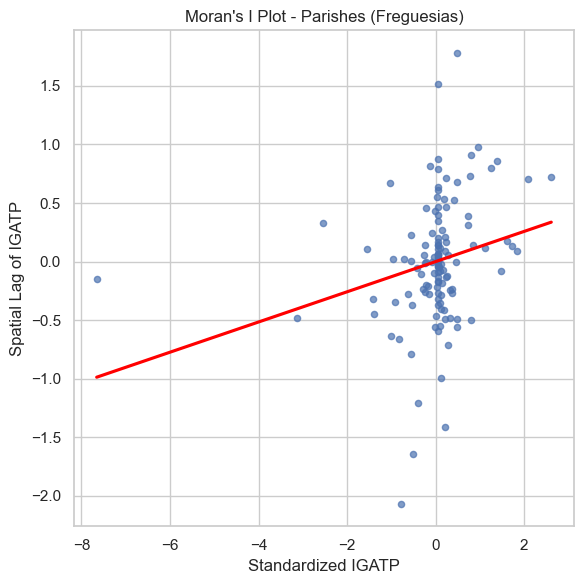

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_6412\1409876756.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


Municipalities (Concelhos) - Moran's I: 0.2751, p-value: 0.0110


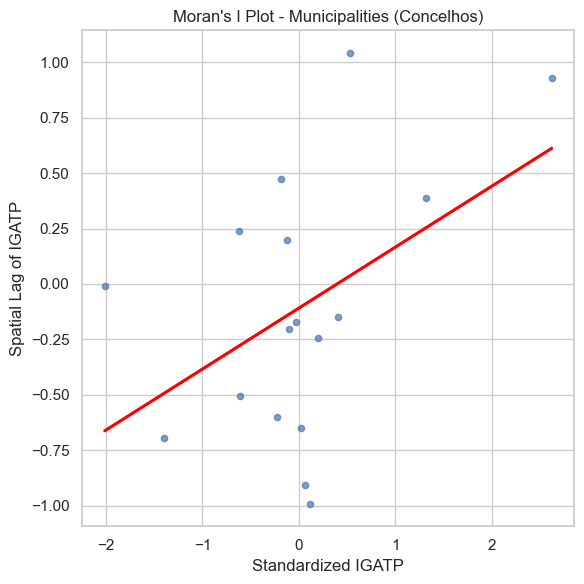

In [27]:
# --- Function to compute Moran's I and plot ---
def compute_moran(geodf, column_name, level_label):
    # Remove missing values
    gdf = geodf.dropna(subset=[column_name])
    
    # Create spatial weights matrix
    w = Queen.from_dataframe(gdf)
    w.transform = 'r'
    
    # Compute Moran's I
    moran = Moran(gdf[column_name], w)

    print(f"{level_label} - Moran's I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")

    # Standardize variable
    z = (gdf[column_name] - gdf[column_name].mean()) / gdf[column_name].std()
    wz = lag_spatial(w, z)

    # Moran scatterplot
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.regplot(
        x=z,
        y=wz,
        ci=None,
        line_kws={'color': 'red'},
        scatter_kws={'s': 20, 'alpha': 0.7}
    )
    ax.set_title(f"Moran's I Plot - {level_label}")
    ax.set_xlabel("Standardized IGATP")
    ax.set_ylabel("Spatial Lag of IGATP")
    plt.tight_layout()
    plt.show()

# --- Apply to IGATP_mean ---
compute_moran(shape_freg_joined, "IGATP_mean", "Parishes (Freguesias)")
compute_moran(gdf_mun_mean, "IGATP_mean", "Municipalities (Concelhos)")

## 7. Local Indicators of Spatial Association (LISA)

While Moran’s I provides a global measure, **LISA** identifies **local clusters** and **outliers**. This allows us to detect:

- **High-High (HH)**: Clusters of high IGATP values
- **Low-Low (LL)**: Clusters of low IGATP values
- **High-Low (HL)** and **Low-High (LH)**: Potential outliers

LISA maps are essential to interpret spatial heterogeneity and guide local-level policy or marketing strategies.

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_6412\1802860414.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 87.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 87, ' is an island (no neighbors)')


c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\esda\moran.py:1059: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Fernanda Costa\.conda\envs\seminario\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(

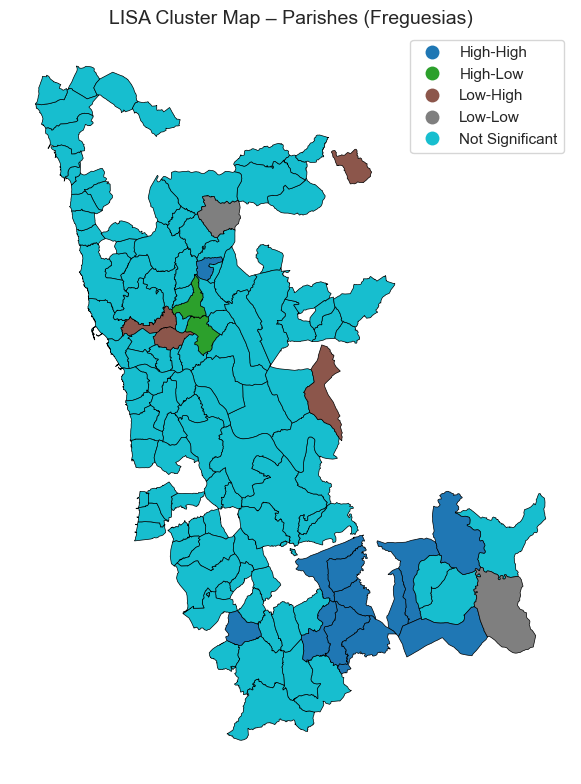

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_6412\1802860414.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


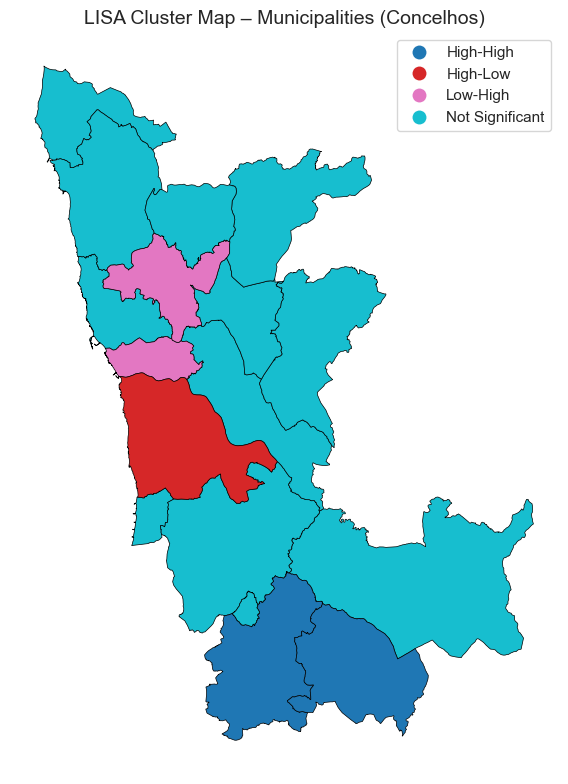

In [28]:
# --- Function to compute and plot LISA ---
def compute_lisa(geodf, column_name, level_label):
    gdf = geodf.dropna(subset=[column_name])
    w = Queen.from_dataframe(gdf)
    w.transform = 'r'
    lisa_model = Moran_Local(gdf[column_name], w)

    # Store cluster category in the GeoDataFrame
    gdf["LISA_cluster"] = lisa_model.q
    gdf["LISA_significance"] = lisa_model.p_sim < 0.05

    # Define labels for clusters
    cluster_labels = {
        1: "High-High",
        2: "Low-Low",
        3: "Low-High",
        4: "High-Low"
    }

    gdf["LISA_category"] = gdf["LISA_cluster"].map(cluster_labels)
    gdf.loc[~gdf["LISA_significance"], "LISA_category"] = "Not Significant"

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    gdf.plot(column="LISA_category", categorical=True, legend=True, ax=ax,
             edgecolor="black", linewidth=0.5)
    ax.set_title(f"LISA Cluster Map – {level_label}", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    
compute_lisa(shape_freg_joined, "IGATP_mean", "Parishes (Freguesias)")
compute_lisa(gdf_mun_mean, "IGATP_mean", "Municipalities (Concelhos)")


## 8. Dominant Topic by Municipality (City-level Aggregation)

In [38]:
df_comments = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/6_unsupervised_learning/ratings_polarity_lda_topics.csv")

In [39]:
df_comments.columns

Index(['Cidade', 'Categoria', 'Nome_Local', 'Autor', 'Texto', 'Data', 'Rating',
       'Idioma', 'Data_Convertida', 'translated_text', 'Texto_Normalizado',
       'Texto_Lematizado', 'Polaridade', 'Polaridade_Média', 'Topic_0',
       'Topic_1', 'Topic_2', 'Topic_3', 'dominant_topic', 'cluster_k6_pam'],
      dtype='object')

In [43]:
# Count how many times each topic appears in each city
topic_counts = df_comments.groupby(["Cidade", "dominant_topic"]).size().reset_index(name="Count")

# For each city, get the most frequent (dominant) topic
dominant_topic_by_city = topic_counts.sort_values("Count", ascending=False).drop_duplicates("Cidade")

# Sort alphabetically by city name (optional)
dominant_topic_by_city = dominant_topic_by_city.sort_values("Cidade").reset_index(drop=True)

# Display result
dominant_topic_by_city

,Cidade,dominant_topic,Count
0,Arouca,Topic_3,192
1,Espinho,Topic_3,205
2,Gondomar,Topic_2,180
3,Maia,Topic_0,208
4,Matosinhos,Topic_3,199
5,Oliveira de Azeméis,Topic_3,185
6,Paredes,Topic_3,190
7,Penafiel,Topic_3,162
8,Porto,Topic_3,213
9,Póvoa de Varzim,Topic_3,221


In [47]:
gdf_points_freg.columns

Index(['Cidade', 'Categoria', 'Nome', 'Rating', 'Endereço', 'Tipos',
       'Latitude', 'Longitude', 'Total_Reviews', 'id_unico', 'Grupo_Tematico',
       'Locais_Semelhantes_Perto', 'Latitude_Nova', 'Longitude_Nova',
       'Endereço_Limpo', 'shrinkage', 'Rating_Bayes', 'Nome_Local',
       'Avg_Polarity', 'Rating_Bayes_norm', 'Popularity_norm',
       'Sentiment_norm', 'IGATP', 'cluster_k2', 'cluster_k3', 'cluster_k6',
       'cluster_k7', 'cluster_k8', 'cluster_k9', 'cluster_k7_pam',
       'cluster_k6_pam', 'geometry', 'index_right', 'DICOFRE_le', 'Freguesia_',
       'Municipio_', 'Distrito_l', 'Area_ha_le', 'Des_Simpli', 'index_righ',
       'DICOFRE_ri', 'Freguesi_1', 'Municipi_1', 'Distrito_r', 'Area_ha_ri',
       'Des_Simp_1'],
      dtype='object')

In [48]:
ranking_freg.columns

Index(['Parish_Code', 'Global Index Mean', 'Parish'], dtype='object')

In [49]:
# Calcular médias por freguesia para todos os índices
mean_freg_all = gdf_points_freg.groupby("DICOFRE_le")[[
    "IGATP", "Rating_Bayes_norm", "Popularity_norm", "Sentiment_norm"
]].mean().reset_index()

# Juntar o nome da freguesia
mean_freg_all = mean_freg_all.merge(
    gdf_freg[["DICOFRE_le", "Freguesia_"]].drop_duplicates(),
    on="DICOFRE_le", how="left"
)

# Reorganizar e renomear colunas
mean_freg_all = mean_freg_all[[
    "DICOFRE_le", "Freguesia_", "IGATP", "Rating_Bayes_norm", "Popularity_norm", "Sentiment_norm"
]]
mean_freg_all.columns = [
    "Parish_Code", "Parish", "IGATP_Mean", "Rating_Bayes_Mean", "Popularity_Mean", "Sentiment_Mean"
]

# Visualizar em tabela
mean_freg_all.head()

,Parish_Code,Parish,IGATP_Mean,Rating_Bayes_Mean,Popularity_Mean,Sentiment_Mean
0,010402,Alvarenga,0.535152,0.884028,0.007745,0.713681
1,010407,Chave,0.563600,0.840531,0.009203,0.841066
2,010409,Escariz,0.516830,0.780538,0.002496,0.767455
3,010413,Mansores,0.503115,0.830616,0.005094,0.673636
4,010414,Moldes,0.501508,0.847969,0.003135,0.653419


In [50]:
# Export the DataFrame to CSV in the current directory
mean_freg_all.to_csv("mean_freg_all_by_parish.csv", index=False, encoding="utf-8-sig")

print("File 'mean_freg_all_by_parish.csv' successfully exported.")

File 'mean_freg_all_by_parish.csv' successfully exported.
